<a href="https://colab.research.google.com/github/Kiran98780/NLP_Assignment2/blob/main/FRESH_TRIAL_9th_May_1_NO_REPLY_Copy_of_BERT_Fine_Tuning_Sentence_Classification_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.2. Installing the Hugging Face Library


In [3]:
!pip install transformers

     |████████████████████████████████| 2.1MB 12.2MB/s 
     |████████████████████████████████| 901kB 56.2MB/s 
     |████████████████████████████████| 3.3MB 53.7MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/NLP_data

/content/drive/My Drive/NLP_data


In [6]:
import pandas as pd
import json
from sklearn import preprocessing
import re
def get_replies(df):
    for index, row in df.iterrows():
        x = re.search(r'\d+', str(row['in_reply_to_status_id_str'])) #check if the string matches a number 
        if x:
            big_list.append(row["sentence"]) #append the reply tweets in a big_list and return the list
        else:
            big_list = []
    return big_list,len(big_list)

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 500)

with open("train.data.jsonl", 'r', encoding='utf-8') as train_data_file:
  list_of_rlists = []
  chunks = []
  num_replies = []
  for line in train_data_file:
    train_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(train_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'sentence'}, inplace=True)
    replies_list,len_reply_list = get_replies(df) #reply list for a single source tweet
    chunks.append(df)
    list_of_rlists.append(replies_list)
    num_replies.append(len_reply_list)
    # print("The output of list_of_rlists in every iteration=",list_of_rlists,"\n",len(list_of_rlists))
  dfs1 = pd.concat(chunks)
train_data_file.close()
#print(dfs1)
print("The len of list of list of replies=", len(list_of_rlists))


with open("train.label.json") as train_label_file:
    train_label_json_file = json.load(train_label_file)
    df_train_label = pd.DataFrame(list(train_label_json_file.items()),columns = ['id', 'label'])
train_label_file.close()

#print(df_train_label)
#print(df_train_label.groupby('label').size())
# non - rumour
# 3058
# rumour
# 1583a

#check the id and if it is present in rumours/non-rumours labels, then add it to the row of that dataframe (check from the labels dataframe)
df_final1 = pd.merge(dfs1, df_train_label, how='left', left_on='id', right_on='id')
df_final2 = pd.merge(dfs1, df_train_label, how='inner', left_on='id', right_on='id')

# print(df_final1)
print(df_final1.shape) #(81120, 7)

# print(df_final2)
print(df_final2.shape) #(4641, 7)


#only text and label - drop columns from old one and store in new one 
Corpus = df_final2.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
le = preprocessing.LabelEncoder()
Corpus['label'] = le.fit_transform(Corpus['label'])
# Corpus["all_replies"] = list_of_rlists #has a list of replies 
# Corpus["num_replies"] = num_replies
print(Corpus.head(10))
print(Corpus.dtypes)
print(Corpus.shape)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The len of list of list of replies= 4641
(81120, 7)
(4641, 7)
                   id                                           sentence  label
0  552800070199148544  How to respond to the murderous attack on Char...      0
1  544388259359387648  You can't condemn an entire race, nation or re...      0
2  552805970536333314  Attempts to extend blame for this to all Musli...      0
3  525071376084791297  Rest in Peace, Cpl. Nathan Cirillo. Killed tod...      1
4  498355319979143168  People DEBATING whether #MikeBrown shoplifted ...      0
5  553591259672379392  Update - PA: gunman holding hostages in #Paris...      1
6  580342401392312321  Here's a recap of the key points so far in the...      0
7  498609222020780033  #Ferguson protestors have shut down a major in...      0
8  544518044643770368  #BREAKING: Police have confirmed Sydney hostag...      0
9  553566877956734976  France faces 2 hostage-taking attacks; Paris k...      1
id          object
sentence    object
label        int64
d

In [7]:
with open("dev.data.jsonl", 'r', encoding='utf-8') as dev_data_file:
  chunks = []
  list_of_rlists = []
  num_replies = []
  for line in dev_data_file:
    dev_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(dev_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'sentence'}, inplace=True)
    replies_list,len_reply_list = get_replies(df)
    chunks.append(df)
    num_replies.append(len_reply_list)
    list_of_rlists.append(replies_list)
  dfs_dev = pd.concat(chunks)
dev_data_file.close()
#print(dfs_dev)

with open("dev.label.json") as dev_label_file:
    dev_label_json_file = json.load(dev_label_file)
    df_dev_label = pd.DataFrame(list(dev_label_json_file.items()),columns = ['id', 'label'])
dev_label_file.close()

#print(df_train_label)
#print(df_train_label.groupby('label').size())
# non - rumour
# 3058
# rumour
# 1583

#check the id and if it is present in rumours/non-rumours labels, then add it to the row of that dataframe (check from the labels dataframe)
df_final1_dev = pd.merge(dfs_dev, df_dev_label, how='left', left_on='id', right_on='id')
df_final2_dev = pd.merge(dfs_dev, df_dev_label, how='inner', left_on='id', right_on='id')

# print(df_final1_dev)
print(df_final1_dev.shape)
# print(df_final2_dev)
print(df_final2_dev.shape)

#only text and label - drop columns from old one and store in new one 
Corpus_dev = df_final2_dev.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
le = preprocessing.LabelEncoder()
Corpus_dev['label'] = le.fit_transform(Corpus_dev['label'])
# Corpus_dev["all_replies"] = list_of_rlists #has a list of replies 
# Corpus_dev["num_replies"] = num_replies
print(Corpus_dev.head(10))
print(Corpus_dev.shape)
print(Corpus_dev.dtypes)


(10546, 7)
(580, 7)
                   id                                           sentence  label
0  553588913747808256  #BREAKING Reports: 2 brothers suspected of Cha...      1
1  524949003834634240  You are not alone today #Ottawa - we are here ...      0
2  553221281181859841  Have said it before, but needs saying again: S...      0
3  580322346508124160  Germanwings #A320 plane crashes in southern Fr...      1
4  544307417677189121  HOSTAGE SITUATION IN SYDNEY\nTo all our fans a...      1
5  499363921661140993  Mound City Bar Association has agreed to donat...      0
6  500177556768034816  Thousands of New Yorkers shut down Times Squar...      0
7  553191800408911872  Mosques attacked in France following 'Charlie ...      0
8  524927281048080385  Snipers set up on National Art Gallery as we r...      1
9  544308793623207936  Remember, Sydney terrorists have nothing to do...      0
(580, 3)
id          object
sentence    object
label        int64
dtype: object


In [8]:
with open("test.data.jsonl", 'r', encoding='utf-8') as test_data_file:
  count_of_all_dicts = 0
  chunks = []
  list_of_rlists = []
  num_replies = []
  for line in test_data_file:
    train_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(train_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'sentence'}, inplace=True)
    replies_list,len_reply_list = get_replies(df)
    chunks.append(df)
    num_replies.append(len_reply_list)
    list_of_rlists.append(replies_list)
  dfs1 = pd.concat(chunks)
test_data_file.close()
#print(dfs1)
finalll = dfs1[dfs1['in_reply_to_status_id_str'].isna()] #source tweets
# print(finalll)

#only text - drop columns from old one and store in new one 
Corpus_test = finalll.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
# Corpus_test["all_replies"] = list_of_rlists #has a list of replies 
# Corpus_test["num_replies"] = num_replies

print(Corpus_test.head(10))
print(Corpus_test.shape)
print(Corpus_test.dtypes)

                   id                                           sentence
0  544382249178001408  5 people have been able to get out of Sydney c...
0  525027317551079424  NEW: Sources: Deceased gunman who killed soldi...
0  544273220128739329  ISIS FLAG VISIBLE AS GUNMAN SEIZES SYDNEY CAFE...
0  499571799764770816  People of #Ferguson: Stop #attacking our brave...
0  552844104418091008  #CharlieHebdo editor, assassinated today, said...
0  524977651476623360  Soldier shot at War Memorial in Ottawa has die...
0  544514988078280704  Gunman in #Sydneysiege identified as Muslim cl...
0  524928863714168832  BREAKING: Injury reported after shooting at Ca...
0  544390718253699072  LIVE: Updates on #SydneySiege via BBC http://t...
0  580322349569994752  Germanwings #A320 plane crashes in southern Fr...
(581, 2)
id          object
sentence    object
dtype: object




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [9]:
#INCLUDE TEST
# Get the lists of sentences and their labels.
sentences = Corpus.sentence.values
labels = Corpus.label.values
sentences1 = Corpus_dev.sentence.values
labels1 = Corpus_dev.label.values
sentences2 = Corpus_test.sentence.values


In [10]:
print(len(sentences1),len(sentences2))

580 581


# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [12]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  How to respond to the murderous attack on Charlie Hebdo? Every newspaper in the free world should print this. http://t.co/sC2ot63F6j
Tokenized:  ['how', 'to', 'respond', 'to', 'the', 'murderous', 'attack', 'on', 'charlie', 'he', '##b', '##do', '?', 'every', 'newspaper', 'in', 'the', 'free', 'world', 'should', 'print', 'this', '.', 'http', ':', '/', '/', 't', '.', 'co', '/', 'sc', '##2', '##ot', '##6', '##3', '##f', '##6', '##j']
Token IDs:  [2129, 2000, 6869, 2000, 1996, 25303, 2886, 2006, 4918, 2002, 2497, 3527, 1029, 2296, 3780, 1999, 1996, 2489, 2088, 2323, 6140, 2023, 1012, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 8040, 2475, 4140, 2575, 2509, 2546, 2575, 3501]


# FIND MAX LEN IN SOURCE TRAIN TWEETS


In [13]:
max_len = 0
countt = 0
# For every sentence...
for sent in sentences:
    countt = countt +1 
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print(countt)
print('Max sentence length: ', max_len)

4641
Max sentence length:  69


# FIND MAX LEN IN SOURCE DEV TWEETS


In [14]:
max_len = 0
countt = 0
# For every sentence...
for sent in sentences1:
    countt = countt +1 
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print(countt)
print('Max sentence length: ', max_len)

580
Max sentence length:  61


Just in case there are some longer test sentences, I'll set the maximum length to 64.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


# TRAIN


In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  How to respond to the murderous attack on Charlie Hebdo? Every newspaper in the free world should print this. http://t.co/sC2ot63F6j
Token IDs: tensor([  101,  2129,  2000,  6869,  2000,  1996, 25303,  2886,  2006,  4918,
         2002,  2497,  3527,  1029,  2296,  3780,  1999,  1996,  2489,  2088,
         2323,  6140,  2023,  1012,  8299,  1024,  1013,  1013,  1056,  1012,
         2522,  1013,  8040,  2475,  4140,  2575,  2509,  2546,  2575,  3501,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# VAL

In [18]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids1 = []
attention_masks1 = []

# For every sentence...
for sent in sentences1:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids1.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks1.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids1 = torch.cat(input_ids1, dim=0)
attention_masks1 = torch.cat(attention_masks1, dim=0)
labels1 = torch.tensor(labels1)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences1[0])
print('Token IDs:', input_ids1[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  #BREAKING Reports: 2 brothers suspected of Charlie Hebdo attack are dead http://t.co/7tGdSv4fr8
Token IDs: tensor([  101,  1001,  4911,  4311,  1024,  1016,  3428,  6878,  1997,  4918,
         2002,  2497,  3527,  2886,  2024,  2757,  8299,  1024,  1013,  1013,
         1056,  1012,  2522,  1013,  1021,  2102,  2290,  5104,  2615,  2549,
        19699,  2620,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# TEST

In [19]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids2 = []
attention_masks2 = []

# For every sentence...
for sent in sentences2:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids2.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks2.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids2 = torch.cat(input_ids2, dim=0)
attention_masks2 = torch.cat(attention_masks2, dim=0)
# labels1 = torch.tensor(labels1)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences2[0])
print('Token IDs:', input_ids2[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  5 people have been able to get out of Sydney cafe during hostage situation: http://t.co/DBgNP6sqFG http://t.co/Q3ECKnYfPV
Token IDs: tensor([  101,  1019,  2111,  2031,  2042,  2583,  2000,  2131,  2041,  1997,
         3994,  7668,  2076, 13446,  3663,  1024,  8299,  1024,  1013,  1013,
         1056,  1012,  2522,  1013, 16962, 16206,  2361,  2575,  2015,  4160,
         2546,  2290,  8299,  1024,  1013,  1013,  1056,  1012,  2522,  1013,
         1053,  2509, 11012,  4890, 22540,  2615,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## 3.4. Training & Validation & Test TENSOR DATASETS



In [20]:
#INCLUDE TEST
from torch.utils.data import TensorDataset

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks, labels)
val_dataset = TensorDataset(input_ids1, attention_masks1, labels1)
test_dataset = TensorDataset(input_ids2, attention_masks2)

# Calculate the number of samples to include in each set.
train_size = int(len(train_dataset))
val_size = int(len(val_dataset))
test_size = int(len(test_dataset))
# val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

4,641 training samples
  580 validation samples
  581 test samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [21]:
#INCLUDE TEST

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [22]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Just for curiosity's sake, we can browse all of the model's parameters by name here.




In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [23]:
# # Get all of the model's parameters as a list of tuples.
# params = list(model.named_parameters())

# print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# print('==== Embedding Layer ====\n')

# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== First Transformer ====\n')

# for p in params[5:21]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== Output Layer ====\n')

# for p in params[-4:]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [24]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [25]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [26]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [27]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [28]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device) #tells pytorch this to the GPU 
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation. 
        result = model(b_input_ids,   #
                       token_type_ids=None, #segment IDS takes 2 sentences 
                       attention_mask=b_input_mask, 
                       labels=b_labels, #return the loss rather than actual labels 
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward() #all of the parameters used while computing that loss- calculate the parameters for every gradient that was involved in calculating that value 

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step() #makes the adjustment to the weigths - based on gradients and LR 

        # Update the learning rate.
        scheduler.step() # key in the LR 

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)    #avy training loss and how long it took is reported          
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # # ========================================
    # #               Validation
    # # ========================================
    # # After the completion of each training epoch, measure our performance on
    # # our validation set.

    # print("")
    # print("Running Validation...")

    # t0 = time.time()

    # # Put the model in evaluation mode--the dropout layers behave differently
    # # during evaluation.
    # model.eval() #tells dropout layer that we are doing evaluation 

    # # Tracking variables 
    # total_eval_accuracy = 0
    # total_eval_loss = 0
    # nb_eval_steps = 0

    # # Evaluate data for one epoch
    # for batch in validation_dataloader:
        
    #     # Unpack this training batch from our dataloader. 
    #     #
    #     # As we unpack the batch, we'll also copy each tensor to the GPU using 
    #     # the `to` method.
    #     #
    #     # `batch` contains three pytorch tensors:
    #     #   [0]: input ids 
    #     #   [1]: attention masks
    #     #   [2]: labels 
    #     b_input_ids = batch[0].to(device)
    #     b_input_mask = batch[1].to(device)
    #     b_labels = batch[2].to(device)
        
    #     # Tell pytorch not to bother with constructing the compute graph during
    #     # the forward pass, since this is only needed for backprop (training).
    #     with torch.no_grad():        #if we run the model in eval mode - saves on compute and memory requirements - not sure why we need this 

    #         # Forward pass, calculate logit predictions.
    #         # token_type_ids is the same as the "segment ids", which 
    #         # differentiates sentence 1 and 2 in 2-sentence tasks.
    #         result = model(b_input_ids, 
    #                        token_type_ids=None, 
    #                        attention_mask=b_input_mask,
    #                        labels=b_labels, #not supplying labels in the video so it returns the output rather than the loss in the  video
    #                        return_dict=True)

    #     # Get the loss and "logits" output by the model. The "logits" are the 
    #     # output values prior to applying an activation function like the 
    #     # softmax.
    #     loss = result.loss
    #     logits = result.logits #
            
    #     # Accumulate the validation loss.
    #     total_eval_loss += loss.item()

    #     # Move logits and labels to CPU
    #     logits = logits.detach().cpu().numpy()
    #     label_ids = b_labels.to('cpu').numpy()

    #     # Calculate the accuracy for this batch of test sentences, and
    #     # accumulate it over all batches.
    #     total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # # Report the final accuracy for this validation run.
    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # # Calculate the average loss over all of the batches.
    # avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # # Measure how long the validation run took.
    # validation_time = format_time(time.time() - t0)
    
    # print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    # print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            # 'Valid. Loss': avg_val_loss,
            # 'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            # 'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    146.    Elapsed: 0:00:08.
  Batch    80  of    146.    Elapsed: 0:00:17.
  Batch   120  of    146.    Elapsed: 0:00:25.

  Average training loss: 0.44
  Training epcoh took: 0:00:30

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    146.    Elapsed: 0:00:08.
  Batch    80  of    146.    Elapsed: 0:00:17.
  Batch   120  of    146.    Elapsed: 0:00:25.

  Average training loss: 0.27
  Training epcoh took: 0:00:30

Training complete!
Total training took 0:01:00 (h:mm:ss)


Let's view the summary of the training process.

In [29]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
# df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Time
epoch,,
1,0.44,0:00:30
2,0.27,0:00:30


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

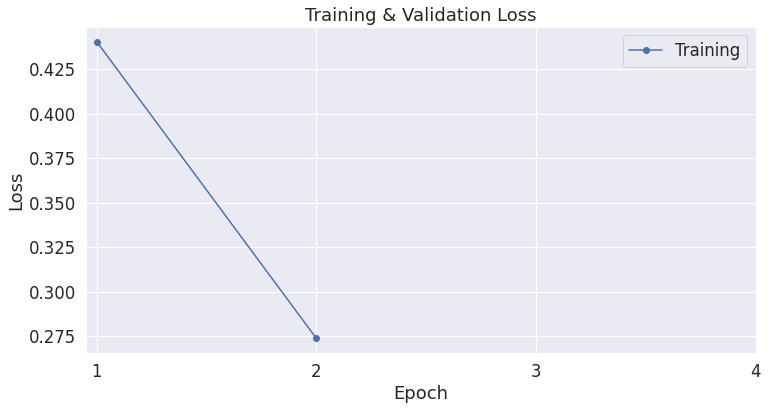

In [30]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [70]:
# import pandas as pd

# # Load the dataset into a pandas dataframe.
# # df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# # Report the number of sentences.
# # print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# # Create sentence and label lists
# sentences1 = Corpus_dev.sentence.values
# labels1 = Corpus_dev.label.values

# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids1 = []
# attention_masks1 = []

# # For every sentence...
# for sent in sentences1:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     encoded_dict = tokenizer.encode_plus(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 128,           # Pad & truncate all sentences.
#                         pad_to_max_length = True,
#                         return_attention_mask = True,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )
    
#     # Add the encoded sentence to the list.    
#     input_ids1.append(encoded_dict['input_ids'])
    
#     # And its attention mask (simply differentiates padding from non-padding).
#     attention_masks1.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
# input_ids1 = torch.cat(input_ids1, dim=0)
# attention_masks1 = torch.cat(attention_masks1, dim=0)
# labels1 = torch.tensor(labels1)

# # Set the batch size.  
# batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids1, attention_masks1, labels1)
# prediction_data = TensorDataset(input_ids2, attention_masks2)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [32]:
# Prediction on val set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids1)))

# Put model in evaluation mode
model.eval()
all_logits = []
# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)
      # all_logits.append(result)

  logits = result.logits
  # all_logits = torch.cat(all_logits, dim=0)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
# probs = F.softmax(predictions, dim=1).cpu().numpy()
print('    DONE.')


Predicting labels for 580 test sentences...
    DONE.


In [33]:
print(type(predictions))
# print(predictions)
# flat_list1 = [sublist for sublist in c for item in predictions]

# print(flat_list1)

<class 'list'>


In [34]:
# logits.argmax(0)
import torch
import torch.nn.functional as F 
# X_train = torch.from_numpy(logits)
out = []
for i in predictions:
    X_train = torch.Tensor(i)
    # print(X_train)
    out.append(X_train)  
print(len(out))
results = torch.cat(out)  #shape (64, 32*in_channels, 224, 224)
print(len(results), results)
probs = F.softmax(results, dim=1)
print(len(probs),probs)

19
580 tensor([[-0.7183,  1.1749],
        [ 1.2732, -2.5834],
        [ 1.5311, -2.8405],
        ...,
        [-0.2368,  0.2000],
        [ 0.4720, -1.3363],
        [ 1.3472, -2.0819]])
580 tensor([[0.1309, 0.8691],
        [0.9793, 0.0207],
        [0.9875, 0.0125],
        ...,
        [0.3925, 0.6075],
        [0.8592, 0.1408],
        [0.9686, 0.0314]])


In [65]:
threshold = 0.55
preds = np.where(probs[:, 1] > threshold, 1, 0)
print(preds)
print(len(preds))

# Number of tweets predicted non-negative
print("Number of tweets predicted rumour: ", preds.sum())

[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1
 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0
 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1
 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1
 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1
 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0
 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 0 0
 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1
 0 0 0 0 1 0 1 0 1 0 0 0 

In [66]:
#predicting 1's and 0's as rumours and non-rumours manually 
final_list = ["rumour" if i == 1 else "non-rumour" for i in preds]
# final_list

In [77]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids2)))

# Put model in evaluation mode
model.eval()
all_logits = []
# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
print('    DONE.')

Predicting labels for 581 test sentences...
    DONE.


In [67]:
# from sklearn import preprocessing
# label_encoder = preprocessing.LabelEncoder()
# label_encoder.fit_transform(Corpus_dev['label'])
# y_predicted_labels = label_encoder.inverse_transform(preds) 
# print(len(y_predicted_labels))
# print(y_predicted_labels)
Corpus_pred = Corpus_dev
Corpus_pred['label'] = final_list
print(Corpus_pred.head())
# Corpus_pred.set_index('id',inplace=True)
dictt = Corpus_pred.to_dict()['label']
print(dictt)
print(len(dictt))



                                                             sentence       label
id                                                                               
553588913747808256  #BREAKING Reports: 2 brothers suspected of Cha...      rumour
524949003834634240  You are not alone today #Ottawa - we are here ...  non-rumour
553221281181859841  Have said it before, but needs saying again: S...  non-rumour
580322346508124160  Germanwings #A320 plane crashes in southern Fr...  non-rumour
544307417677189121  HOSTAGE SITUATION IN SYDNEY\nTo all our fans a...  non-rumour
{'553588913747808256': 'rumour', '524949003834634240': 'non-rumour', '553221281181859841': 'non-rumour', '580322346508124160': 'non-rumour', '544307417677189121': 'non-rumour', '499363921661140993': 'non-rumour', '500177556768034816': 'non-rumour', '553191800408911872': 'non-rumour', '524927281048080385': 'non-rumour', '544308793623207936': 'non-rumour', '553223882128490496': 'non-rumour', '553587546614427649': 'non-rumour

In [68]:
with open("dev.baseline_03_BERT_FT.json", "w") as outfile: 
    json.dump(dictt, outfile)

In [76]:
# import pandas as pd

# # Load the dataset into a pandas dataframe.
# # df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# # Report the number of sentences.
# # print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# # Create sentence and label lists
# sentences1 = Corpus_dev.sentence.values
# labels1 = Corpus_dev.label.values

# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids1 = []
# attention_masks1 = []

# # For every sentence...
# for sent in sentences1:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     encoded_dict = tokenizer.encode_plus(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 128,           # Pad & truncate all sentences.
#                         pad_to_max_length = True,
#                         return_attention_mask = True,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )
    
#     # Add the encoded sentence to the list.    
#     input_ids1.append(encoded_dict['input_ids'])
    
#     # And its attention mask (simply differentiates padding from non-padding).
#     attention_masks1.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
# input_ids1 = torch.cat(input_ids1, dim=0)
# attention_masks1 = torch.cat(attention_masks1, dim=0)
# labels1 = torch.tensor(labels1)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
# prediction_data = TensorDataset(input_ids1, attention_masks1, labels1)
prediction_data = TensorDataset(input_ids2, attention_masks2)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [78]:
# logits.argmax(0)
import torch
import torch.nn.functional as F 
# X_train = torch.from_numpy(logits)
out = []
for i in predictions:
    X_train = torch.Tensor(i)
    # print(X_train)
    out.append(X_train)  
print(len(out))
results = torch.cat(out)  #shape (64, 32*in_channels, 224, 224)
print(len(results), results)
probs = F.softmax(results, dim=1)
print(len(probs),probs)

threshold = 0.55
preds = np.where(probs[:, 1] > threshold, 1, 0)
print(preds)
print(len(preds))
# Number of tweets predicted non-negative
print("Number of tweets predicted rumour: ", preds.sum())

final_list = ["rumour" if i == 1 else "non-rumour" for i in preds]

Corpus_pred = Corpus_test
Corpus_pred['label'] = final_list
print(Corpus_pred.head())
Corpus_pred.set_index('id',inplace=True)
dictt = Corpus_pred.to_dict()['label']
print(dictt)
print(len(dictt))





19
581 tensor([[-0.8618,  1.4527],
        [-1.4758,  2.1241],
        [-0.9063,  1.3650],
        ...,
        [-0.0937,  0.7326],
        [ 1.2584, -2.4921],
        [ 1.0571, -2.0318]])
581 tensor([[0.0899, 0.9101],
        [0.0266, 0.9734],
        [0.0935, 0.9065],
        ...,
        [0.3044, 0.6956],
        [0.9770, 0.0230],
        [0.9564, 0.0436]])
[1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0
 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0
 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 0
 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 

In [79]:
with open("test.baseline_03_BERT_FT.json", "w") as outfile: 
    json.dump(dictt, outfile)

Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [39]:
# print('Positive samples: %d of %d (%.2f%%)' % (Corpus_dev.label.sum(), len(Corpus_dev.label), (Corpus_dev.label.sum() / len(Corpus_dev.label) * 100.0)))

TypeError: ignored

In [40]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


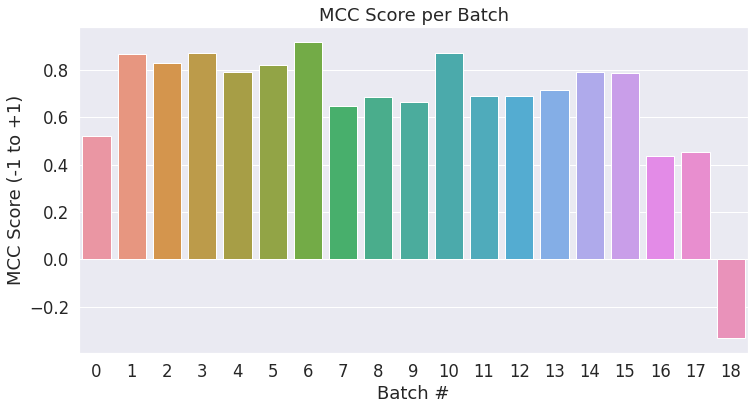

In [41]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [42]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.717


Cool! In about half an hour and without doing any hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.) we are able to get a good score. 

> *Note: To maximize the score, we should remove the "validation set" (which we used to help determine how many epochs to train for) and train on the entire training set.*

The library documents the expected accuracy for this benchmark [here](https://huggingface.co/transformers/examples.html#glue) as `49.23`.

You can also look at the official leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy). 

Note that (due to the small dataset size?) the accuracy can vary significantly between runs.


# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Appendix


## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [43]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [44]:
!ls -l --block-size=K ./model_save/

total 427988K
-rw------- 1 root root      1K May  8 15:43 config.json
-rw------- 1 root root 427759K May  8 15:43 pytorch_model.bin
-rw------- 1 root root      1K May  8 15:43 special_tokens_map.json
-rw------- 1 root root      1K May  8 15:43 tokenizer_config.json
-rw------- 1 root root    227K May  8 15:43 vocab.txt


The largest file is the model weights, at around 418 megabytes.

In [45]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw------- 1 root root 418M May  8 15:43 ./model_save/pytorch_model.bin


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [46]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

IndentationError: ignored

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

The following functions will load the model back from disk.

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

## A.2. Weight Decay



The huggingface example includes the following code block for enabling weight decay, but the default decay rate is "0.0", so I moved this to the appendix.

This block essentially tells the optimizer to not apply weight decay to the bias terms (e.g., $ b $ in the equation $ y = Wx + b $ ). Weight decay is a form of regularization--after calculating the gradients, we multiply them by, e.g., 0.99.

In [ ]:
# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

# Revision History

**Version 4** - *Feb 2nd, 2020* - (current)
* Updated all calls to `model` (fine-tuning and evaluation) to use the [`SequenceClassifierOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput) class.
* Moved illustration images to Google Drive--Colab appears to no longer support images at external URLs.

**Version 3** - *Mar 18th, 2020*
* Simplified the tokenization and input formatting (for both training and test) by leveraging the `tokenizer.encode_plus` function. 
`encode_plus` handles padding *and* creates the attention masks for us.
* Improved explanation of attention masks.
* Switched to using `torch.utils.data.random_split` for creating the training-validation split.
* Added a summary table of the training statistics (validation loss, time per epoch, etc.).
* Added validation loss to the learning curve plot, so we can see if we're overfitting. 
    * Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing this!
* Displayed the per-batch MCC as a bar plot.

**Version 2** - *Dec 20th, 2019* - [link](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP)
* huggingface renamed their library to `transformers`. 
* Updated the notebook to use the `transformers` library.

**Version 1** - *July 22nd, 2019*
* Initial version.

## Further Work

* It might make more sense to use the MCC score for “validation accuracy”, but I’ve left it out so as not to have to explain it earlier in the Notebook.
* Seeding -- I’m not convinced that setting the seed values at the beginning of the training loop is actually creating reproducible results…
* The MCC score seems to vary substantially across different runs. It would be interesting to run this example a number of times and show the variance.
